In [1]:
# Packge Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np 
import pandas as pd
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt
from sklearn import metrics, utils
from PIL import Image
import os
import keras.backend as K
import re
import statistics
%matplotlib inline

In [2]:
TRAIN_CLASSIFIER = True
LOAD_CLASSIFIER = not TRAIN_CLASSIFIER # Inverse logic on train vs load
CLASSIFIER_MODEL_FN = '../input/watchdog-models/GTSRB_CNN_Model.h5'

TRAIN_AUTOENCODER = True
LOAD_AUTOENCODER = not TRAIN_AUTOENCODER
AE_MODEL_FN = '../input/watchdog-models/Autoencoder_Model.h5'

TRAIN_GAN = True
LOAD_GAN = not TRAIN_GAN
GAN_MODEL_FN = '../input/watchdog-models/GAN_Model_0.1.h5'

TRAIN_BINARY_CLASSIFIER = False
LOAD_BINARY_CLASSIFIER = False
BINARY_CLASSIFIER_MODEL_FN = '../input/models/Bin_Classifier_Model_0.05.h5'


In [3]:
# create a base path for the road signs
BASE_PATH = '../input/gtsrb-german-traffic-sign/'
ADV_BASE_PATH = '../input/chinese-traffic-signs/'

# read the Training.csv and Test.csv files into dataframes
training_dataframe = pd.read_csv(BASE_PATH + 'Train.csv')
test_dataframe = pd.read_csv(BASE_PATH + 'Test.csv')

# read the adverse_dataframe
adverse_dataframe = pd.read_csv(ADV_BASE_PATH + 'annotations.csv')
adverse_dataframe.columns = ['Path', 'w', 'h', 'x1', 'y1', 'x2', 'y2', 'ClassId']


In [4]:
#NUM_CLASSES = adverse_dataframe['ClassId'].nunique() # Calculate the number of unique classes
NUM_CLASSES = training_dataframe['ClassId'].nunique() # Calculate the number of unique classes

TRAIN_LEN = training_dataframe['ClassId'].count()
TEST_LEN = test_dataframe['ClassId'].count()
print("Number of Classes: ", NUM_CLASSES) # debug print, dataset contains 43 classes
print("Number of Data Samples: ", TRAIN_LEN) # debug print
print("Number of Data Samples test: ", TEST_LEN) # debug print

Number of Classes:  43
Number of Data Samples:  39209
Number of Data Samples test:  12630


In [5]:
training_dataframe['ClassId']=training_dataframe['ClassId'].astype('str') # converting class type to string
adverse_dataframe['ClassId']=adverse_dataframe['ClassId'].astype('str') # converting class type to string

training_dataframe = pd.concat([training_dataframe['Path'], training_dataframe['ClassId']], axis = 1) # simplify the dataframe by removing ROI and H/W information.
training_dataframe = utils.shuffle(training_dataframe) # Shuffling the dataframe 
training_dataframe.head() # check to ensure dataframe has been shuffled.


adv_frame = pd.concat([adverse_dataframe['Path'], adverse_dataframe['ClassId']], axis = 1)
tst_frame = pd.concat([test_dataframe['Path'], test_dataframe['ClassId']], axis = 1)
print(adv_frame.head())
print(tst_frame.head())

image_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.25,
    fill_mode = 'nearest')


           Path ClassId
0  000_0001.png       0
1  000_0002.png       0
2  000_0003.png       0
3  000_0010.png       0
4  000_0011.png       0
             Path  ClassId
0  Test/00000.png       16
1  Test/00001.png        1
2  Test/00002.png       38
3  Test/00003.png       33
4  Test/00004.png       11


In [6]:
# Define hyperparameters for the generators
BATCH_SIZE = 128
IMG_SIZE = (32, 32) # Fixing the image size is a required for our Neural Network. This size may be adjusted as needed.

# Create the training and validation generators
image_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split= 0.25,
    fill_mode = 'nearest')

# Training Generator
train_gen = image_gen.flow_from_dataframe(
    training_dataframe,
    directory=BASE_PATH,
    x_col='Path',
    y_col='ClassId',
    class_mode='categorical',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=128,
    subset="training",
)

ae_gen = image_gen.flow_from_dataframe(
    training_dataframe,
    directory=BASE_PATH,
    x_col='Path',
    class_mode = 'input',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=128,
    subset='training',
)

aev_gen = image_gen.flow_from_dataframe(
    training_dataframe,
    directory=BASE_PATH,
    x_col='Path',
    class_mode = 'input',
    target_size=IMG_SIZE,
    color_mode='rgb',
    subset='validation',
    batch_size = 4096,
)

# Validation Generator
val_gen = image_gen.flow_from_dataframe(
    training_dataframe,
    directory=BASE_PATH,
    x_col="Path",
    y_col='ClassId',
    class_mode = 'categorical',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=4096,
    subset="validation",
)

 

frames = [adv_frame, tst_frame]
eval_frame = pd.concat(frames)

badclasst_gen = image_gen.flow_from_dataframe(
    adv_frame,
    directory=ADV_BASE_PATH+'/images',
    x_col='Path',
    y_col='ClassId',
    class_mode='categorical',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=-1,
    subset='training'
)

badclassv_gen = image_gen.flow_from_dataframe(
    adv_frame,
    directory=ADV_BASE_PATH+'/images',
    x_col='Path',
    y_col='ClassId',
    class_mode='categorical',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=4096,
    subset='validation'
)

badimg_gen = image_gen.flow_from_dataframe(
    adv_frame,
    directory=ADV_BASE_PATH+'/images',
    x_col='Path',
    class_mode = 'input',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size = 4096,
)


test_dataframe['ClassId'] = test_dataframe['ClassId'].astype('str')


evaluation_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0,
    fill_mode = 'nearest')


# Test Generator
test_gen = evaluation_gen.flow_from_dataframe(
    test_dataframe,
    directory=BASE_PATH,
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=10000,
)


Found 29407 validated image filenames belonging to 43 classes.
Found 29407 validated image filenames.
Found 9802 validated image filenames.
Found 9802 validated image filenames belonging to 43 classes.
Found 4623 validated image filenames belonging to 58 classes.
Found 1541 validated image filenames belonging to 58 classes.
Found 6164 validated image filenames.
Found 12630 validated image filenames belonging to 43 classes.


In [7]:
[test_imgs, test_labs] = next(test_gen)
print(test_imgs.shape)
print(test_labs.shape)

print(test_labs[1])

(10000, 32, 32, 3)
(10000, 43)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# Load CIFAR10 and CIFAR100 Image datasets - test subset only
(_,_),(cifar10_imgs, cifar10_labs) = tf.keras.datasets.cifar10.load_data()
(_,_),(cifar100_imgs, cifar100_labs) = tf.keras.datasets.cifar100.load_data()



# Force Cifar100 to be labeled 0-9 in generic cateogires, ignoring subcategories
for i in range(len(cifar100_labs)):
    cifar10_labs[i] = np.floor(cifar10_labs[i] * 4.3)
    cifar100_labs[i] = cifar100_labs[i] % 43


         
cifar_imgs = np.append(cifar10_imgs, cifar100_imgs, axis=0)
cifar_labs = np.append(cifar10_labs, cifar100_labs, axis=0)

cifar_imgs = cifar_imgs/255.0

# Debug prints to ensure fewer than 43 classes
print(np.unique(cifar10_labs))        
print(np.unique(cifar100_labs))
print(np.unique(cifar_labs))
    
print(cifar_imgs.shape)
print(cifar_labs.shape)

# Cast cifar labels into 43 classes for easy evaluation in classifier.
cifar_labs = tf.keras.utils.to_categorical(cifar_labs, num_classes = NUM_CLASSES)

print(cifar_labs.shape) # Verify shape


169009152/169001437 [==============================] - 3s 0us/step
[ 0  4  8 12 17 21 25 30 34 38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
(20000, 32, 32, 3)
(20000, 1)
(20000, 43)


In [9]:
evaluation_images = np.append(test_imgs, cifar_imgs, axis=0)
evaluation_labels = np.append(test_labs, cifar_labs, axis=0)
print(evaluation_images.shape)
print(evaluation_labels.shape)

# test_imgs/test_labs - GTSRB Only
# cifar_imgs/cifar_labs - Cifar10/100 Only
# evaluation_images/evaluation_labels - mixed distribution set

(30000, 32, 32, 3)
(30000, 43)


In [10]:
# Hyperparameters for the Neural Networks
KERNEL_SIZE = (3,3)
POOL_SIZE = (2,2)
FILTERS = 16
dropout = 0.35
EPOCHS = 25
img_shape = (32, 32, 3) # Defined above in the generator section. 
gimg_shape = (32, 32, 3)


classifier = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=img_shape, padding='same'),
    tf.keras.layers.Conv2D(filters=FILTERS*2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(filters=FILTERS*4, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.Conv2D(filters=FILTERS*8, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


# Plot the classifier model to a .png file 
tf.keras.utils.plot_model (classifier, to_file = 'classifier_structure.png', 
                           show_shapes = True)

# Compile the model using adam optimizer.
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
            metrics = ['accuracy'])

# Print a summary of the model for quick observation
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0

In [11]:
ae = tf.keras.models.Sequential()
ae.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=gimg_shape, name='e_1_conv2d', padding='same'))
ae.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='e_2_conv2d', padding='same'))
ae.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='e_3_max_pooling2d'))
ae.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='e_4_conv2d'))
ae.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name='e_5_conv2d'))
ae.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='e_6_max_pooling2d'))
ae.add(tf.keras.layers.Flatten(name='e_7_flatten'))
ae.add(tf.keras.layers.Dense(800, activation='relu', name='e_8_dense'))
ae.add(tf.keras.layers.Dense(3200, activation='relu', name='d_1_dense'))
ae.add(tf.keras.layers.Reshape((5, 5, 128), name='d_2_reshape'))
ae.add(tf.keras.layers.UpSampling2D(size=(2, 2), name='d_3_up_sampling2d'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', name='d_4_conv2d_transpose'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', name='d_5_conv2d_transpose'))
ae.add(tf.keras.layers.UpSampling2D(size=(2, 2), name='d_6_up_sampling2d'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', name='d_7_conv2d_transpose'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size = (3,3), activation = 'relu', name='d_8_conv2d_transpose'))
ae.summary()

# Plot the classifier model to a .png file 
tf.keras.utils.plot_model (ae, to_file = 'autoencoder_structure.png', 
                           show_shapes = True)



# Compile the model using adam optimizer.
ae.compile(loss = 'MSE', optimizer = 'adam',
            metrics = ['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_1_conv2d (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
e_2_conv2d (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
e_3_max_pooling2d (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
e_4_conv2d (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
e_5_conv2d (Conv2D)          (None, 12, 12, 128)       73856     
_________________________________________________________________
e_6_max_pooling2d (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
e_7_flatten (Flatten)        (None, 4608)             

In [12]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, mode='auto')

if TRAIN_CLASSIFIER:
    class_history = classifier.fit(x = train_gen, 
                   epochs = EPOCHS-5, 
                   validation_data = val_gen, 
                   verbose = True,
                   callbacks = [callbacks])

    classifier.save("GTSRB_CNN_Model.h5")

if TRAIN_AUTOENCODER:
    ae_history = ae.fit(x = ae_gen,
                       epochs = EPOCHS,
                       validation_data = aev_gen,
                       verbose = True,
                       callbacks = [callbacks])

    ae.save("Autoencoder_Model.h5")
    
if LOAD_AUTOENCODER:
    ae = tf.keras.models.load_model(AE_MODEL_FN)

Epoch 1/20
230/230 [==============================] - 221s 944ms/step - loss: 3.1046 - accuracy: 0.2237 - val_loss: 6.6005 - val_accuracy: 0.0594
Epoch 2/20
230/230 [==============================] - 58s 252ms/step - loss: 1.1488 - accuracy: 0.6274 - val_loss: 3.5298 - val_accuracy: 0.1567
Epoch 3/20
230/230 [==============================] - 60s 260ms/step - loss: 0.7067 - accuracy: 0.7626 - val_loss: 1.0112 - val_accuracy: 0.6842
Epoch 4/20
230/230 [==============================] - 61s 266ms/step - loss: 0.5105 - accuracy: 0.8278 - val_loss: 0.4882 - val_accuracy: 0.8402
Epoch 5/20
230/230 [==============================] - 61s 267ms/step - loss: 0.4005 - accuracy: 0.8641 - val_loss: 0.3993 - val_accuracy: 0.8675
Epoch 6/20
230/230 [==============================] - 60s 263ms/step - loss: 0.3136 - accuracy: 0.8926 - val_loss: 0.5283 - val_accuracy: 0.8313
Epoch 7/20
230/230 [==============================] - 59s 257ms/step - loss: 0.2781 - accuracy: 0.9058 - val_loss: 0.4320 - val_a

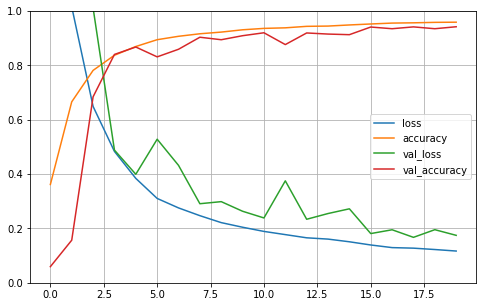

In [13]:
if TRAIN_CLASSIFIER:
    pd.DataFrame(class_history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [14]:
# Evaluate the classifier with data from our test generator
predict=classifier.predict(test_imgs)
preds = []


(10000, 43)
10000


<AxesSubplot:ylabel='Count'>

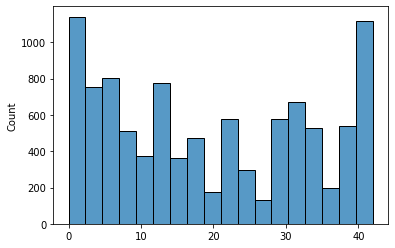

In [15]:
print(np.shape(predict))
print(len(predict))
for i in range(len(predict)):
    preds.append(np.argmax(predict[i]))

genimgs = ae.predict(test_imgs)
sns.histplot(preds)



In [16]:
bi_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.25,
    fill_mode = 'nearest')


dataset_path = '../input/gan-gen-imgs/GAN_IMGS/train'

test_dataset_path = '../input/gan-gen-imgs/GAN_IMGS/test'

biclass_gen = bi_gen.flow_from_directory(directory=dataset_path,
                                                target_size=(32,32),
                                                color_mode = 'rgb',
                                                classes = None,
                                                class_mode = 'categorical',
                                                shuffle = True,
                                                seed = 16,
                                                batch_size=64
                                               )

images, labels = next(biclass_gen)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

Found 70129 images belonging to 2 classes.
float32 (64, 32, 32, 3)
float32 (64, 2)


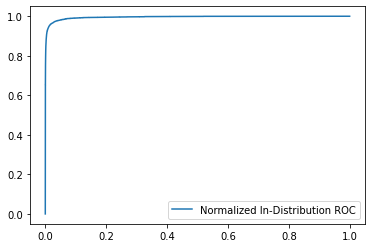

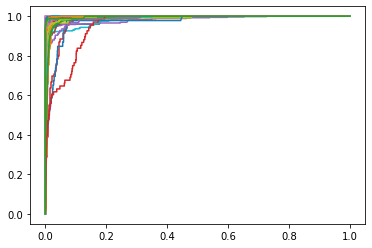

In [17]:
# Get ROC Curves
fprt = dict()
tprt = dict()


for i in range(NUM_CLASSES):
    fprt[i], tprt[i], _ = metrics.roc_curve(test_labs[:, i], predict[:, i])
    
fprt["micro"], tprt["micro"], _ = metrics.roc_curve(test_labs.ravel(), predict.ravel())


plt.figure()
plt.plot(fprt['micro'], tprt['micro'], label='Normalized In-Distribution ROC')
plt.legend()
plt.savefig('classifier_ugroc.png')


plt.figure()
for i in range(NUM_CLASSES):
      plt.plot(fprt[i], tprt[i])

plt.savefig('classifier_allclass.png')

938/938 [==============================] - 11s 11ms/step - loss: 7.0505 - accuracy: 0.3093
7.05054235458374 0.3093000054359436


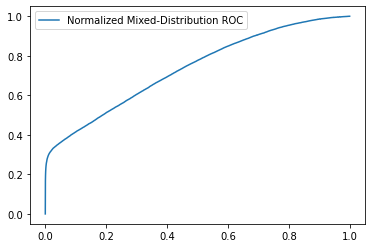

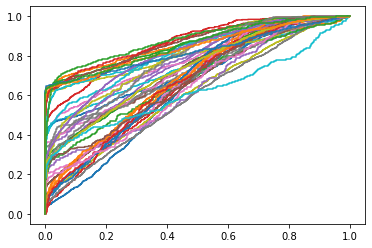

In [18]:
# Evaluate the classifier with data from our test generator

evaluation=classifier.predict(evaluation_images)

for i in range(NUM_CLASSES):
    fprt[i], tprt[i], _ = metrics.roc_curve(evaluation_labels[:, i], evaluation[:, i])
    
fprt["micro"], tprt["micro"], _ = metrics.roc_curve(evaluation_labels.ravel(), evaluation.ravel())


plt.figure()
plt.plot(fprt['micro'], tprt['micro'], label='Normalized Mixed-Distribution ROC')
plt.legend()
plt.savefig('classifier_eval_roc.png')


plt.figure()
for i in range(NUM_CLASSES):
      plt.plot(fprt[i], tprt[i])

plt.savefig('classifier_eval_allclass.png')

loss, acc = classifier.evaluate(evaluation_images, evaluation_labels)

print(loss, acc)

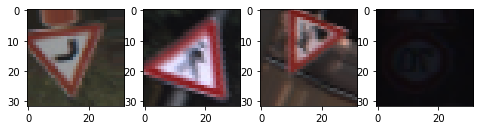

<Figure size 432x288 with 0 Axes>

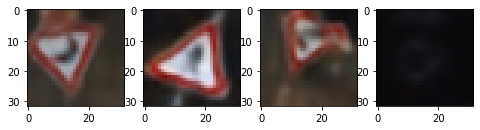

0.9033553210519215
0.9237587175155763
0.8252166476111894
0.975563900096393


<Figure size 432x288 with 0 Axes>

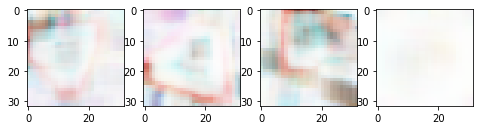

/opt/conda/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


<Figure size 432x288 with 0 Axes>

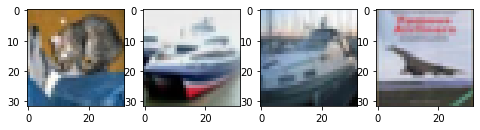

<Figure size 432x288 with 0 Axes>

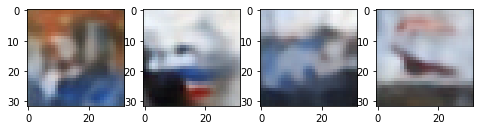

0.7520960487675509
0.7664961766067774
0.8610609722103605
0.8080842806556756


<Figure size 432x288 with 0 Axes>

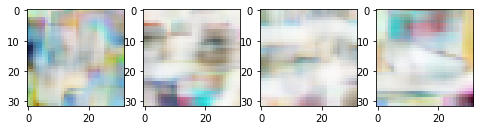

<Figure size 432x288 with 0 Axes>

In [19]:
def img_rmse(image1, image2):
    error = np.sqrt(np.sum((image1.astype('float')-image2.astype('float'))**2))
    return error

goodimgs=next(aev_gen)
goodimgs=goodimgs[1]
goodgen=ae.predict(goodimgs)

diff_scores=[]
diff_imgs=[]

for i in range(1024):
    score,img = ssim(goodimgs[i], goodgen[i], full=True, multichannel=True)
    diff_scores.append(score)
    diff_imgs.append(img)
    


plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(goodimgs[i])

plt.show()
plt.savefig('origin.png')    
    
plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(goodgen[i])

plt.show()
plt.savefig('regen.png')



plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(diff_imgs[i])
    print(diff_scores[i])

plt.show()
plt.savefig('ssim_diff.png')

diff_scores=[]
diff_imgs=[]


cifargen=ae.predict(cifar_imgs)

for i in range(4):
    score,img = ssim(cifar_imgs[i], cifargen[i], full=True, multichannel=True)
    diff_scores.append(score)
    diff_imgs.append(img)
    


plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(cifar_imgs[i])

plt.show()
plt.savefig('origin.png')    
    
plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(cifargen[i])

plt.show()
plt.savefig('regen.png')



plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(diff_imgs[i])
    print(diff_scores[i])

plt.show()
plt.savefig('ssim_diff.png')

In [20]:
#evaluation_images, evaluation_labels

evaluation_binary_labels = np.zeros(len(evaluation_labels))
print(len(evaluation_binary_labels))
evaluation_binary_labels[:10000] = 1
print(evaluation_binary_labels[9999])

print(evaluation_binary_labels.shape)

evaluation_binary_labels = tf.keras.utils.to_categorical(evaluation_binary_labels)

print(evaluation_binary_labels.shape)

ae_gen_eval = ae.predict(evaluation_images)

ssim_diff = []

for i in range(len(ae_gen_eval)):
    score, img = ssim(evaluation_images[i], ae_gen_eval[i], full=True, multichannel=True)
    ssim_diff.append(score)
    

30000
1.0
(30000,)
(30000, 2)


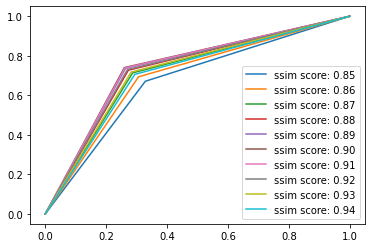

In [21]:

fpr = dict()
tpr = dict()

for j in range(50):
    estimated_labels = np.zeros(30000)
    for i in range(len(evaluation_binary_labels)):
        if ssim_diff[i] > (.45 + j/100): 
            estimated_labels[i] = 1
        else:
            estimated_labels[i] = 0        
    estimated_labels = tf.keras.utils.to_categorical(estimated_labels)
    fpr[j], tpr[j], _ = metrics.roc_curve(evaluation_binary_labels.ravel(), estimated_labels.ravel())


# Plot SSIM scores for .85-.95
for i in range(10):
    plt.plot(fpr[i+40],tpr[i+40], label = 'ssim score: {:.2f}' ''.format(.85+(i/100)))
    plt.legend()

In [22]:
# GAN

def reset_weights(layer):
    if isinstance(layer, tf.keras.Model):
        reset_weights(layer)
    else:
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))


gan = tf.keras.models.clone_model(ae)
gan.summary()

for layer in gan.layers:
    if re.match(r"e_*", layer.name):
        gan.get_layer(layer.name).trainable = False
        print(layer.name, '(encoder layer)')
    else:
        reset_weights(gan.get_layer(layer.name))
        print(layer.name, '(decoder layer)')

    
    
print("weights:", len(gan.weights))
print("trainable_weights:", len(gan.trainable_weights))
print("non_trainable_weights:", len(gan.non_trainable_weights))
    


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_1_conv2d (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
e_2_conv2d (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
e_3_max_pooling2d (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
e_4_conv2d (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
e_5_conv2d (Conv2D)          (None, 12, 12, 128)       73856     
_________________________________________________________________
e_6_max_pooling2d (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
e_7_flatten (Flatten)        (None, 4608)             

In [ ]:
# train GAN
# threshold = 0.05 # mean ssim gan (threshold  0.05 ): 0.9435866659549421
threshold = 0.1 # 

if TRAIN_GAN:
    GAN_model_filename = "GAN_model_%s.h5" % threshold
    # Prepare an optimizer.
    optimizer = tf.keras.optimizers.Adam()
    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(-1 * loss_rec)
    # Prepare a loss function.
    def ssim_loss(y_true, y_pred):
        return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


    loss_fn = ssim_loss

    # Iterate over the batches of a dataset.
    for epoch in range(EPOCHS):
        print('Epoch', epoch)
        batches = 0
        e_loss = 0
        best_eloss = 9999999.9
        e_no_improvemet = -1
        # Prepare the training dataset. 
        # dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        # dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
        dataset = ae_gen
        for inputs, targets in dataset:
            # Open a GradientTape.
            with tf.GradientTape() as tape:
                # Forward pass.
                predictions = gan(inputs)
                # Compute the loss value for this batch.
                gan_loss_value = loss_fn(inputs, predictions)
                watchdog_loss_value = loss_fn(predictions, ae(predictions))
                loss_to_data = 1 - gan_loss_value
                loss_watchdog = 1 - watchdog_loss_value

                loss_value1 = K.abs(threshold - loss_to_data)
                loss_value2 = K.abs(threshold - loss_watchdog)
                loss_value3 = loss_to_data - threshold
                loss_value4 = loss_watchdog - threshold
                if loss_value3 < 0:
                    loss_value3 = loss_value3 * 0
                if loss_value4 < 0:
                    loss_value4 = loss_value4 * 0

                loss_value = (loss_value1 + loss_value2 + loss_value3 + loss_value4)/4
                #      loss_value = (loss_value3 + loss_value4)/2
                #      loss_value = loss_value4

            # Get gradients of loss wrt the weights.
            gradients = tape.gradient(loss_value, gan.trainable_weights)
            # Update the weights of the model.
            optimizer.apply_gradients(zip(gradients, gan.trainable_weights))

            batches += 1
            e_loss += loss_value
            if batches % 32 == 0:
                print('Batch', batches, 'loss', e_loss/batches)

            if batches >= TRAIN_LEN / BATCH_SIZE:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        e_loss = e_loss/batches
        print('Epoch', epoch, 'loss', e_loss)
        if e_loss < best_eloss:
            best_eloss = e_loss
            e_no_improvement = 0
            gan.save(GAN_model_filename)
            print('callback: saving model in: ', GAN_model_filename)
        else:
            e_no_improvement +=1
            
        if e_no_improvement == 5:
            print('callback: no more patience (5 epochs without improvement). Best loss value on the saved model: ', best_eloss)
            print('current model loss value: ', e_loss)
            print('load the saved model for the best results or go ahead with this loss value, it is up to you :)')
            break


if LOAD_GAN:
    gan = tf.keras.models.load_model(GAN_MODEL_FN)
    

Epoch 0
Batch 32 loss tf.Tensor(0.2651418, shape=(), dtype=float32)
Batch 64 loss tf.Tensor(0.23426467, shape=(), dtype=float32)
Batch 96 loss tf.Tensor(0.21583806, shape=(), dtype=float32)
Batch 128 loss tf.Tensor(0.20199914, shape=(), dtype=float32)
Batch 160 loss tf.Tensor(0.1904468, shape=(), dtype=float32)
Batch 192 loss tf.Tensor(0.1811346, shape=(), dtype=float32)
Batch 224 loss tf.Tensor(0.17346123, shape=(), dtype=float32)
Batch 256 loss tf.Tensor(0.16696914, shape=(), dtype=float32)
Batch 288 loss tf.Tensor(0.16145098, shape=(), dtype=float32)
Epoch 0 loss tf.Tensor(0.1584767, shape=(), dtype=float32)
callback: saving model in:  GAN_model_0.1.h5
Epoch 1
Batch 32 loss tf.Tensor(0.108388565, shape=(), dtype=float32)
Batch 64 loss tf.Tensor(0.10899651, shape=(), dtype=float32)
Batch 96 loss tf.Tensor(0.10700608, shape=(), dtype=float32)
Batch 128 loss tf.Tensor(0.10540791, shape=(), dtype=float32)
Batch 160 loss tf.Tensor(0.104105756, shape=(), dtype=float32)
Batch 192 loss tf.T

In [ ]:
# GAN check

# german
goodimgs=next(aev_gen)
goodimgs=goodimgs[1]
goodgan=gan.predict(goodimgs)
gen_from_gan = ae.predict(goodgan)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(goodimgs[i])

plt.show()
#plt.savefig('Original_Good_Signs.png')

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(goodgan[i])

plt.show()
#plt.savefig('GAN_Good_Signs.png')

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gen_from_gan[i])

plt.show()
#plt.savefig('gen_from_GAN_Good_Signs.png')


gan_german_diff_imgs = []
gan_german_diff_scores = []
gan_genfromgan_diff_imgs = []
gan_genfromgan_diff_scores = []

# german signs
for i in range(1024):
    score,img = ssim(goodimgs[i], goodgan[i], full=True, multichannel=True)
    gan_german_diff_scores.append(score)
    gan_german_diff_imgs.append(img)
#     if((score > .88) & (score < .90)):
#         plt.imshow(gan_german_diff_imgs[i])
#         plt.savefig('sign_image_' + str(i) +'.png')
#         plt.close('all')
        


for i in range(1024):
    score,img = ssim(goodgan[i], gen_from_gan[i], full=True, multichannel=True)
    gan_genfromgan_diff_scores.append(score)
    gan_genfromgan_diff_imgs.append(img)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gan_genfromgan_diff_imgs[i])

plt.show()
#plt.figure()
plt.plot(gan_german_diff_scores, 'rs')
plt.plot(gan_genfromgan_diff_scores, 'g-')
print('mean ssim gan (threshold ', threshold, '):', statistics.mean(gan_genfromgan_diff_scores))

In [ ]:
bin_classifier = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    tf.keras.layers.Cropping2D((2, 2)),
    tf.keras.layers.Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.Conv2D(filters=FILTERS*2, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(filters=FILTERS*4, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.Conv2D(filters=FILTERS*8, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    
    tf.keras.layers.Dense(2, activation='softmax')
])


# Plot the classifier model to a .png file 
tf.keras.utils.plot_model (bin_classifier, to_file = 'bin_classifier_structure.png', 
                           show_shapes = True)

# Compile the model using adam optimizer.
bin_classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam',
            metrics = ['accuracy'])

# Print a summary of the model for quick observation
print(bin_classifier.summary())

In [ ]:
bi_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.25,
    fill_mode = 'nearest')


dataset_path = '../input/gan-gen-imgs/GAN_IMGS/train'

test_dataset_path = '../input/gan-gen-imgs/GAN_IMGS/test'

biclass_gen = bi_gen.flow_from_directory(directory=dataset_path,
                                                target_size=(32,32),
                                                color_mode = 'rgb',
                                                classes = None,
                                                class_mode = 'categorical',
                                                shuffle = True,
                                                seed = 16,
                                                batch_size=64
                                               )

images, labels = next(biclass_gen)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)


biclass_eval = bi_gen.flow_from_directory(directory=test_dataset_path,
                                               target_size = (32, 32),
                                               color_mode = 'rgb',
                                               classes = None,
                                               class_mode = 'categorical',
                                               shuffle = False,
                                               seed = 16,
                                                batch_size=64
                                               )


In [ ]:
bin_classifier.fit(biclass_gen,
                  epochs = 5,
                  validation_data = biclass_eval,
                  verbose = True,
                  callbacks = [callbacks])

In [ ]:
# evaluation_binary_labels, evaluation_labels, evaluation_images

fpr = dict()
tpr = dict()

biclass_preds = bin_classifier.predict(evaluation_images)

print(biclass_preds.shape)
print(evaluation_binary_labels.shape)

fpr[1], tpr[1], _ = metrics.roc_curve(evaluation_binary_labels.ravel(), biclass_preds.ravel())

plt.figure()
plt.plot(fpr[1], tpr[1])


In [ ]:
# First Layer placeholder
FLI = []
FLL = []
FLB = []
# Second Layer placeholder
SLI = []
SLL = []
SLB = []
regen_imgs = ae.predict(evaluation_images)

# First Tier Autoencoder

for i in range(len(regen_imgs)):
    score,img = ssim(evaluation_images[i], regen_imgs[i], full=True, multichannel=True)
    if score >=.89:
        FLI.append(evaluation_images[i])
        FLL.append(evaluation_labels[i])
        FLB.append(evaluation_binary_labels[i])


FLI=np.array(FLI)
FLL=np.array(FLL)
FLB=np.array(FLB)
bipreds = bin_classifier.predict(FLI)

for i in range(len(bipreds)):
    if(np.argmax(bipreds[i])==0):
        SLI.append(FLI[i])
        SLL.append(FLL[i])
        SLB.append(FLB[i])

SLI=np.array(SLI)
SLL=np.array(SLL)

        

In [ ]:
print(FLI.shape)
print(FLL.shape)

print(SLI.shape)
print(SLL.shape)

class_preds = classifier.predict(SLI)

fpr[1], tpr[1], _ = metrics.roc_curve(SLL.ravel(), class_preds.ravel())

plt.plot(fpr[1], tpr[1], label='Mixed Distribution Guarded ROC')
plt.legend()

In [ ]:
# Evaluate the classifier with data from our test generator
predict=classifier.predict(test_imgs)
evaluation=classifier.predict(evaluation_images)
class_preds = classifier.predict(SLI)

fprt = dict()
tprt = dict()


# Generate False Positive and True Psoitive rates from roc_curve function
fprt['guard'], tprt['guard'], _ = metrics.roc_curve(SLL.ravel(), class_preds.ravel())    
fprt["indist"], tprt["indist"], _ = metrics.roc_curve(test_labs.ravel(), predict.ravel())
fprt["eval"], tprt["eval"], _ = metrics.roc_curve(evaluation_labels.ravel(), evaluation.ravel())


# Plot ROC curves for unguarded, independent, and guarded networks
plt.figure()
plt.plot(fprt['indist'], tprt['indist'], label='Normalized In-Distribution ROC')
plt.plot(fprt['eval'], tprt['eval'], label='Unguarded Mixed-Distribution ROC')
plt.plot(fprt['guard'], tprt['guard'], label='Watchdog Guarded ROC')
plt.legend()
plt.savefig('final_results_roc.png')

loss, acc = classifier.evaluate(SLI, SLL)

In [ ]:
imgs, labs = next(biclass_gen)

plt.figure(figsize=(8,8))
for i in range(4) :   
    plt.subplot(1,4,(i+1))
    plt.imshow(imgs[i])

plt.show()
plt.savefig('generated_imgs.png')    